In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.ticker as ticker
from IPython.display import Audio
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

sns.set()
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)

In [2]:
#Features
features = pd.read_excel('Hot 100 Audio Features.xlsx')

In [3]:
#Billboard Top 100 By Week from 1958 to 2021
bb100 = pd.read_csv('Hot Stuff.csv')

In [4]:
#Convert 'WeekID' to DateTime Object & Check First & Last 2 entries by Week/Year
bb100['WeekID'] = pd.DatetimeIndex(bb100['WeekID'])
bb100.sort_values(by='WeekID').iloc[np.r_[0:2, -2:0]]

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
18553,http://www.billboard.com/charts/hot-100/1958-08-02,1958-08-02,63,High School Confidential,Jerry Lee Lewis And His Pumping Piano,High School ConfidentialJerry Lee Lewis And His Pumping Piano,1,NaN,63,1
103337,http://www.billboard.com/charts/hot-100/1958-08-02,1958-08-02,98,Little Serenade,The Ames Brothers,Little SerenadeThe Ames Brothers,1,NaN,98,1
300806,https://www.billboard.com/charts/hot-100/2021-05-29,2021-05-29,61,Almost Maybes,Jordan Davis,Almost MaybesJordan Davis,2,64.0,61,17
152154,https://www.billboard.com/charts/hot-100/2021-05-29,2021-05-29,78,White Teeth,YoungBoy Never Broke Again,White TeethYoungBoy Never Broke Again,1,NaN,78,1


In [5]:
#Merge BB100 with Features
bb100_features = pd.merge(bb100, features, on='SongID', how='left')
print(bb100_features.shape)
bb100_features.head(2)

(330461, 31)


,url,WeekID,Week Position,Song_x,Performer_x,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,Performer_y,Song_y,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,spotify_track_album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
0,http://www.billboard.com/charts/hot-100/1965-07-17,1965-07-17,34,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,45.0,34,4,Patty Duke,Don't Just Stand There,['deep adult standards'],1YhNCQ3XOdTCZgubfX8PgB,NaN,163160.0,0.0,Lost Hits Of The 60's (All Original Artists & Versions),0.574,0.256,7.0,-15.044,1.0,0.0298,0.61,0.000077,0.1,0.568,82.331,3.0,21.0
1,http://www.billboard.com/charts/hot-100/1965-07-24,1965-07-24,22,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,34.0,22,5,Patty Duke,Don't Just Stand There,['deep adult standards'],1YhNCQ3XOdTCZgubfX8PgB,NaN,163160.0,0.0,Lost Hits Of The 60's (All Original Artists & Versions),0.574,0.256,7.0,-15.044,1.0,0.0298,0.61,0.000077,0.1,0.568,82.331,3.0,21.0


In [6]:
#Taking some important columns to introduce Spotify Metrics
subset_1 = bb100_features[['WeekID','Song_x', 'spotify_track_preview_url', 'danceability', 'spotify_track_popularity']]
print(subset_1.shape)
subset_1.head(2)

(330461, 5)


,WeekID,Song_x,spotify_track_preview_url,danceability,spotify_track_popularity
0,1965-07-17,Don't Just Stand There,NaN,0.574,21.0
1,1965-07-24,Don't Just Stand There,NaN,0.574,21.0


In [7]:
#Remove all Nan's from subset_1
subset_1 = subset_1.dropna()
print(subset_1.shape)
subset_1.head(2)

(169763, 5)


,WeekID,Song_x,spotify_track_preview_url,danceability,spotify_track_popularity
14,1971-04-24,Don't Knock My Love - Pt. 1,https://p.scdn.co/mp3-preview/5d3332b4ae616cd2157f948f7329b20470714a95?cid=b8d3901151d34489a160e3cf0ab1fa94,0.731,26.0
15,1971-05-01,Don't Knock My Love - Pt. 1,https://p.scdn.co/mp3-preview/5d3332b4ae616cd2157f948f7329b20470714a95?cid=b8d3901151d34489a160e3cf0ab1fa94,0.731,26.0


In [8]:
#Remove all duplicate songs from subset_1
subset_1 = subset_1.drop_duplicates(subset='Song_x')
print(subset_1.shape)
subset_1.head(2)

(12689, 5)


,WeekID,Song_x,spotify_track_preview_url,danceability,spotify_track_popularity
14,1971-04-24,Don't Knock My Love - Pt. 1,https://p.scdn.co/mp3-preview/5d3332b4ae616cd2157f948f7329b20470714a95?cid=b8d3901151d34489a160e3cf0ab1fa94,0.731,26.0
39,1989-09-30,Don't Know Much,https://p.scdn.co/mp3-preview/49fff23849dc6ec86909dd299908100857831882?cid=b8d3901151d34489a160e3cf0ab1fa94,0.401,60.0


In [9]:
#Sort by Danceability Score and make smaller dataframe from Danceability, Spotify Track Popularity, Preview URL
Danceability = subset_1.sort_values(by='danceability', ascending=False)
#Danceability = Danceability[['Song_x','danceability', 'spotify_track_popularity','spotify_track_preview_url']]
Danceability.head(3)

,WeekID,Song_x,spotify_track_preview_url,danceability,spotify_track_popularity
11957,2017-03-04,Cash Me Outside (#CashMeOutside),https://p.scdn.co/mp3-preview/5211a8b66228ed666534003556e44cabe9cea7a3?cid=b8d3901151d34489a160e3cf0ab1fa94,0.981,45.0
2551,1984-06-30,State of Shock,https://p.scdn.co/mp3-preview/c8c39ac37e4cfc5ae80266d7d855bc73d2ba1573?cid=b8d3901151d34489a160e3cf0ab1fa94,0.980,43.0
144665,2019-08-17,Uno,https://p.scdn.co/mp3-preview/793f081dafcd15fa18e76556449aab02d59eabf5?cid=b8d3901151d34489a160e3cf0ab1fa94,0.978,76.0


In [10]:
Danceability.describe()

,danceability,spotify_track_popularity
count,12689.000000,12689.000000
mean,0.601022,39.671369
std,0.153474,22.605779
min,0.000000,0.000000
25%,0.499000,21.000000
50%,0.609000,41.000000
75%,0.711000,58.000000
max,0.981000,100.000000


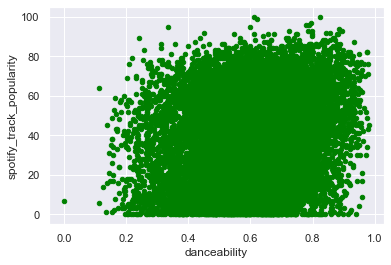

In [11]:
Danceability.plot.scatter(x='danceability', y='spotify_track_popularity', c='green');

In [12]:
Low = Danceability.loc[(Danceability['danceability'] < 0.20 ) & (Danceability['WeekID'] < '1979-1-1') &
                 (Danceability['spotify_track_popularity'] > 55)]
Low

,WeekID,Song_x,spotify_track_preview_url,danceability,spotify_track_popularity
53743,1978-08-19,Lights,https://p.scdn.co/mp3-preview/51c5e725889996cb3cdf92ba06927bd161f7a8f9?cid=b8d3901151d34489a160e3cf0ab1fa94,0.193,60.0
105019,1968-11-30,If I Can Dream,https://p.scdn.co/mp3-preview/a277ad09e179423f6e88b6a887cfe02df7d31f57?cid=b8d3901151d34489a160e3cf0ab1fa94,0.182,58.0


In [13]:
Low.iloc[0]

WeekID                                                                                                               1978-08-19 00:00:00
Song_x                                                                                                                            Lights
spotify_track_preview_url    https://p.scdn.co/mp3-preview/51c5e725889996cb3cdf92ba06927bd161f7a8f9?cid=b8d3901151d34489a160e3cf0ab1fa94
danceability                                                                                                                       0.193
spotify_track_popularity                                                                                                            60.0
Name: 53743, dtype: object

In [14]:
#Get 'Lights' preview URL:
Lights = Low['spotify_track_preview_url'].iloc[0]
Lights

'https://p.scdn.co/mp3-preview/51c5e725889996cb3cdf92ba06927bd161f7a8f9?cid=b8d3901151d34489a160e3cf0ab1fa94'

In [15]:
#Download URL and save as MP3 file: 
import urllib.request
url = Lights
filename = 'Dance_Score_0.19.mp3'
urllib.request.urlretrieve(url, filename)

('Dance_Score_0.19.mp3', <http.client.HTTPMessage at 0x7fa17f71f310>)

In [16]:
#Play MP3 file: 
from IPython.display import Audio
Audio('Dance_Score_0.19.mp3')

In [17]:
Danceability = Danceability.loc[Danceability['spotify_track_popularity'] > 85]
Danceability.shape

(74, 5)

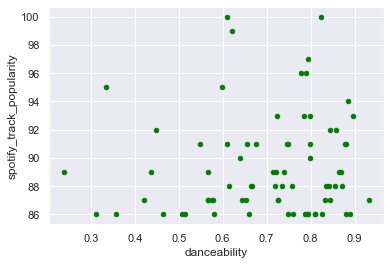

In [18]:
Danceability.plot.scatter(x='danceability', y='spotify_track_popularity', c='green');

In [19]:
#High Danceability Score on Spotify: 
Danceability.head(10)

,WeekID,Song_x,spotify_track_preview_url,danceability,spotify_track_popularity
11590,2019-09-21,223's,https://p.scdn.co/mp3-preview/3b3cbec1fa7d67c39c0fe5f274e438c4f1cc35b5?cid=b8d3901151d34489a160e3cf0ab1fa94,0.932,87.0
41391,2019-12-21,The Box,https://p.scdn.co/mp3-preview/52c74a85b9b187b8f51bfe1c7b19a25f7624161a?cid=b8d3901151d34489a160e3cf0ab1fa94,0.896,93.0
7489,2018-12-15,Going Bad,https://p.scdn.co/mp3-preview/29e19c68dd853994221a90103db28427f1185e33?cid=b8d3901151d34489a160e3cf0ab1fa94,0.889,86.0
146446,2019-12-07,Vete,https://p.scdn.co/mp3-preview/2803e299f302d099cd11449e450d5bf21749fec5?cid=b8d3901151d34489a160e3cf0ab1fa94,0.886,94.0
7477,2019-12-28,Futsal Shuffle 2020,https://p.scdn.co/mp3-preview/ab9ea4c65ee7c5ef65a55c1667ca522114da4c5c?cid=b8d3901151d34489a160e3cf0ab1fa94,0.881,91.0
29040,2020-06-13,Ride It.,https://p.scdn.co/mp3-preview/2c4acac07bd693cb02d0ad8021d78b5854801e59?cid=b8d3901151d34489a160e3cf0ab1fa94,0.880,86.0
9637,2019-03-16,Old Town Road,https://p.scdn.co/mp3-preview/d94ec2ebe62fd52cf038760f57c251c145346bb2?cid=b8d3901151d34489a160e3cf0ab1fa94,0.878,91.0
7851,2017-09-16,Jocelyn Flores,https://p.scdn.co/mp3-preview/9fd5ccc86f318c303d582800e9f7d6f07f40440b?cid=b8d3901151d34489a160e3cf0ab1fa94,0.872,88.0
145502,2021-02-20,Up,https://p.scdn.co/mp3-preview/83c0198f658d22ae67250a28430f7089715c4797?cid=b8d3901151d34489a160e3cf0ab1fa94,0.868,89.0
294817,2019-11-23,Yellow Hearts,https://p.scdn.co/mp3-preview/50e8f9fbb9aa384e554c261c0a8701d411ceffdb?cid=b8d3901151d34489a160e3cf0ab1fa94,0.865,89.0


In [20]:
#Get 'Ride It' preview URL:
Ride_it_URL = Danceability['spotify_track_preview_url'].iloc[5]
Ride_it_URL

'https://p.scdn.co/mp3-preview/2c4acac07bd693cb02d0ad8021d78b5854801e59?cid=b8d3901151d34489a160e3cf0ab1fa94'

In [21]:
#Cross Check Series
Danceability['spotify_track_preview_url'].head(10)

11590     https://p.scdn.co/mp3-preview/3b3cbec1fa7d67c39c0fe5f274e438c4f1cc35b5?cid=b8d3901151d34489a160e3cf0ab1fa94
41391     https://p.scdn.co/mp3-preview/52c74a85b9b187b8f51bfe1c7b19a25f7624161a?cid=b8d3901151d34489a160e3cf0ab1fa94
7489      https://p.scdn.co/mp3-preview/29e19c68dd853994221a90103db28427f1185e33?cid=b8d3901151d34489a160e3cf0ab1fa94
146446    https://p.scdn.co/mp3-preview/2803e299f302d099cd11449e450d5bf21749fec5?cid=b8d3901151d34489a160e3cf0ab1fa94
7477      https://p.scdn.co/mp3-preview/ab9ea4c65ee7c5ef65a55c1667ca522114da4c5c?cid=b8d3901151d34489a160e3cf0ab1fa94
29040     https://p.scdn.co/mp3-preview/2c4acac07bd693cb02d0ad8021d78b5854801e59?cid=b8d3901151d34489a160e3cf0ab1fa94
9637      https://p.scdn.co/mp3-preview/d94ec2ebe62fd52cf038760f57c251c145346bb2?cid=b8d3901151d34489a160e3cf0ab1fa94
7851      https://p.scdn.co/mp3-preview/9fd5ccc86f318c303d582800e9f7d6f07f40440b?cid=b8d3901151d34489a160e3cf0ab1fa94
145502    https://p.scdn.co/mp3-preview/83c0198f658d22ae

In [22]:
#Download URL and save as MP3 file: 
import urllib.request
url = Ride_it_URL
filename = 'Dance_Score_0.88.mp3'
urllib.request.urlretrieve(url, filename)

('Dance_Score_0.88.mp3', <http.client.HTTPMessage at 0x7fa17f0e1760>)

In [23]:
#Play MP3 file: 
from IPython.display import Audio
Audio('Dance_Score_0.88.mp3')

In [24]:
#Low Danceability Score on Spotify: 
Danceability.tail(10)

,WeekID,Song_x,spotify_track_preview_url,danceability,spotify_track_popularity
33114,2019-03-30,Slow Dancing In The Dark,https://p.scdn.co/mp3-preview/483355f39bb264b9828633561ab14a7a48e75270?cid=b8d3901151d34489a160e3cf0ab1fa94,0.515,86.0
8446,2021-05-22,Higher Power,https://p.scdn.co/mp3-preview/494d59484c6dbe0b181e7c0371e4aefd1c04a2d2?cid=b8d3901151d34489a160e3cf0ab1fa94,0.507,86.0
5877,2019-01-05,Blue Christmas,https://p.scdn.co/mp3-preview/ddcfe1df4783b2e41f494dec4b13917fb8e1465d?cid=b8d3901151d34489a160e3cf0ab1fa94,0.465,86.0
20105,2021-02-27,Heartbreak Anniversary,https://p.scdn.co/mp3-preview/680c39287fb49fdcb9e6690a1419a97fe67d8420?cid=b8d3901151d34489a160e3cf0ab1fa94,0.449,92.0
7980,2021-01-09,Good Days,https://p.scdn.co/mp3-preview/297942feb416d50b8ee69f760daf1e2a1f39dabc?cid=b8d3901151d34489a160e3cf0ab1fa94,0.436,89.0
17203,2013-09-21,All Of Me,https://p.scdn.co/mp3-preview/488c53471e56ff9f629652691444438951e880bb?cid=b8d3901151d34489a160e3cf0ab1fa94,0.422,87.0
22493,2016-11-12,Say You Won't Let Go,https://p.scdn.co/mp3-preview/00825cb1779b31d68964eda6f2a7911fc2ae96c6?cid=b8d3901151d34489a160e3cf0ab1fa94,0.358,86.0
9593,2000-01-08,All I Want For Christmas Is You,https://p.scdn.co/mp3-preview/ab4f06069148ef8510d8681164479601d4617bed?cid=b8d3901151d34489a160e3cf0ab1fa94,0.335,95.0
2463,2010-12-18,Christmas Lights,https://p.scdn.co/mp3-preview/83bc99b80b9bd0115cbd1ff6447152f60f8c4386?cid=b8d3901151d34489a160e3cf0ab1fa94,0.312,86.0
8238,2017-01-07,It's The Most Wonderful Time Of The Year,https://p.scdn.co/mp3-preview/6b5b5e401c3803f9ff6ff877fe79fae9f22e162b?cid=b8d3901151d34489a160e3cf0ab1fa94,0.240,89.0


In [25]:
#Get 'All of Me' preview URL:
All_Of_Me = Danceability['spotify_track_preview_url'].iloc[-5]
All_Of_Me

'https://p.scdn.co/mp3-preview/488c53471e56ff9f629652691444438951e880bb?cid=b8d3901151d34489a160e3cf0ab1fa94'

In [26]:
#Download URL and save as MP3 file: 
#import urllib.request
url = All_Of_Me
filename = 'Dance_Score_0.42.mp3'
urllib.request.urlretrieve(url, filename)

('Dance_Score_0.42.mp3', <http.client.HTTPMessage at 0x7fa17f0e15e0>)

In [27]:
#Play MP3 file: 
from IPython.display import Audio
Audio('Dance_Score_0.42.mp3')